### “PRP” 변수를 예측하는 Pipeline 기반 다중 회귀 모델링

In [123]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msn

In [124]:
# 데이터 로드
data = pd.read_csv("machine.data.csv")

data
data.columns

Index(['VendorName', 'ModelName', 'MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN',
       'CHMAX', 'PRP', 'ERP'],
      dtype='object')

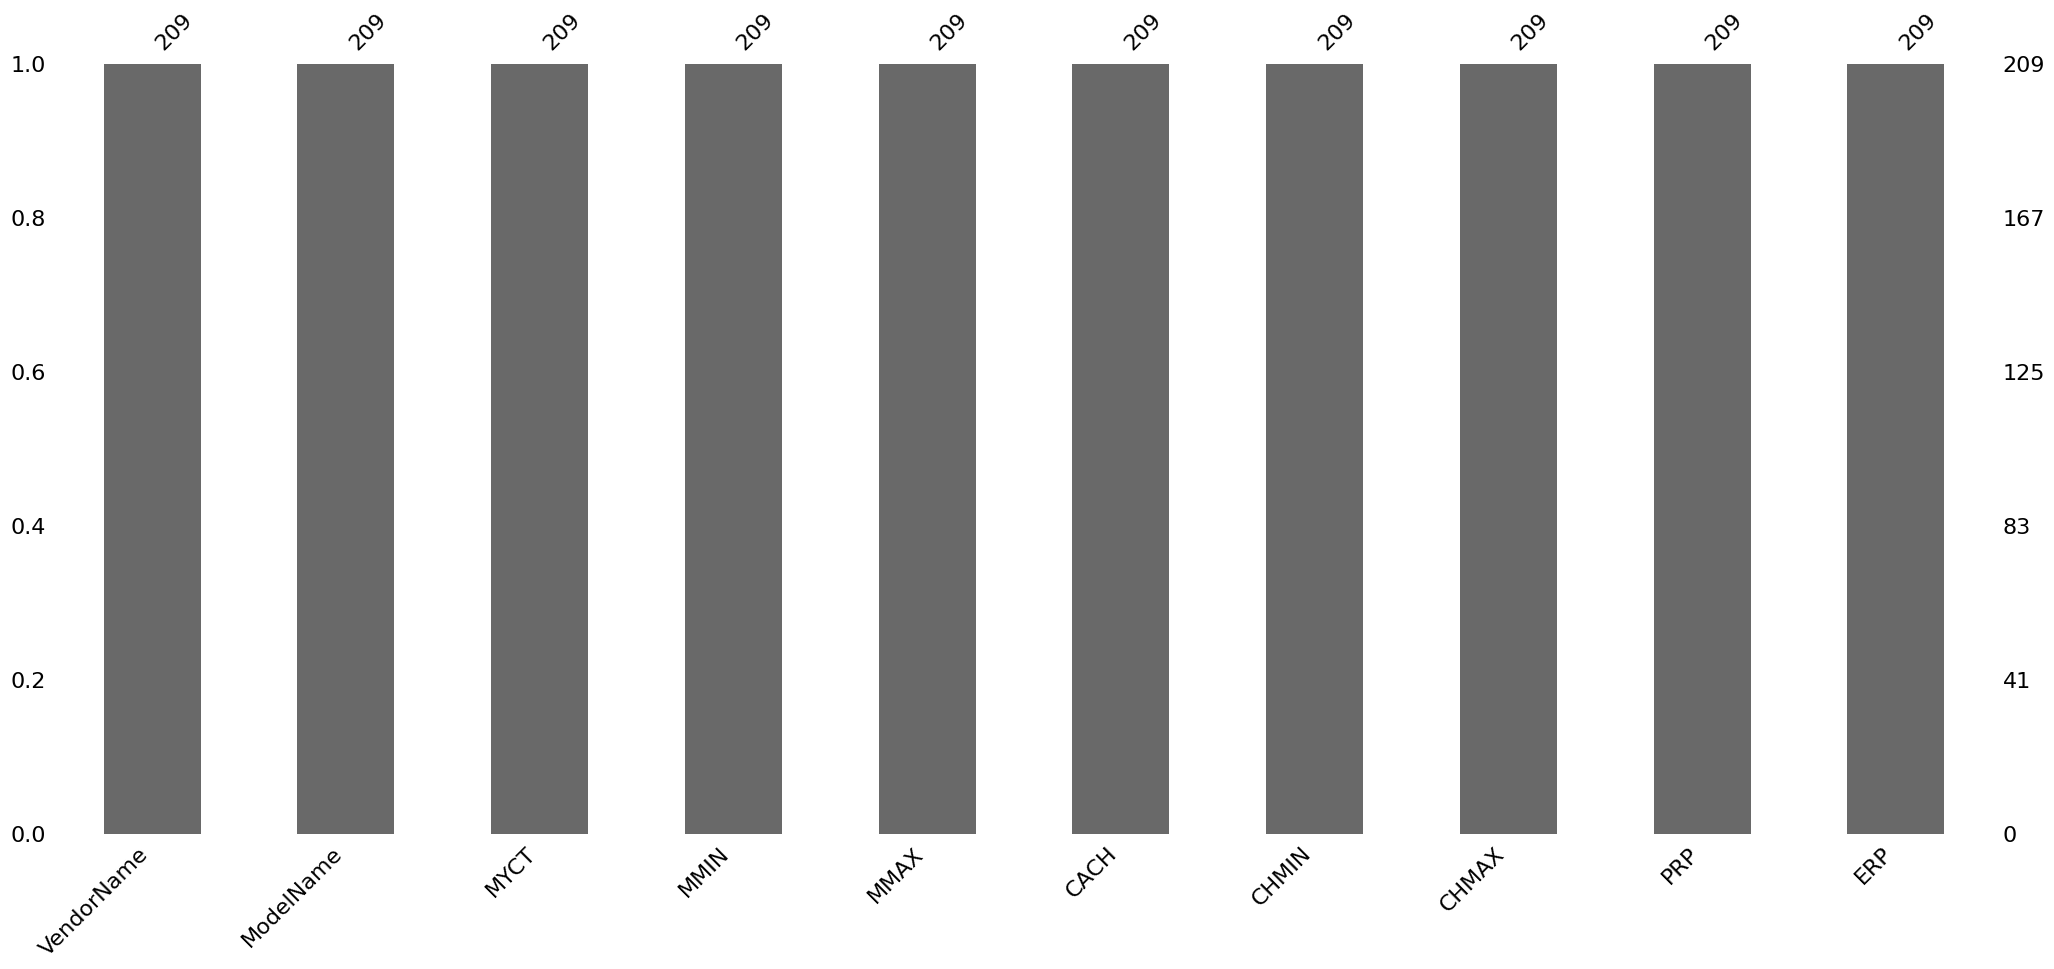

In [125]:
# 결측값 찾기
msn.bar(data)

# 결측치 처리
data.dropna(inplace = True)

PRP                        1.000000
ERP                        0.966472
MMAX                       0.863004
MMIN                       0.794931
CACH                       0.662641
                             ...   
ModelName_v8655            0.002430
ModelName_as/6650          0.002324
ModelName_50-850-ii        0.001460
ModelName_as/7000-n        0.000269
ModelName_cyber:170/835    0.000163
Name: PRP, Length: 247, dtype: float64


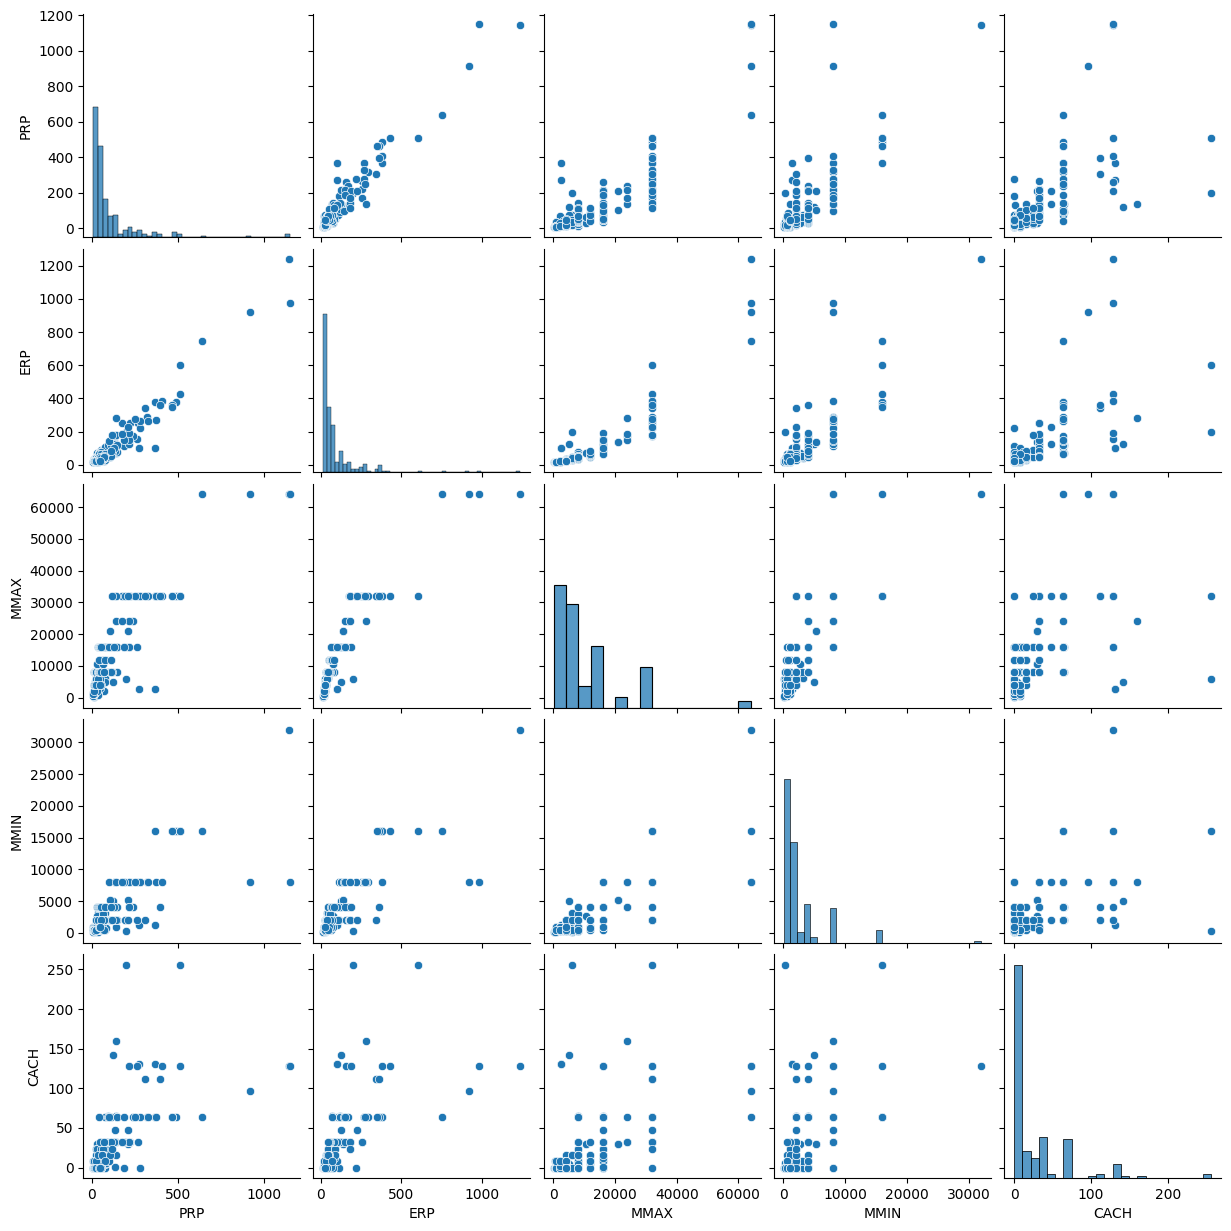

In [126]:
# 범주형 데이터 수치화
data = pd.get_dummies(data, columns=['VendorName', 'ModelName'], dtype=float)

# 상관계수 계산
correlation_matrix = data.corr()

# PRP와의 상관계수 추출
prp_correlation = correlation_matrix['PRP']

# 상관계수를 절대값으로 변환
prp_correlation = np.abs(prp_correlation)

# 상관계수를 내림차순으로 정렬
prp_correlation_sorted = prp_correlation.sort_values(ascending=False)

# 상관계수 출력
print(prp_correlation_sorted)

# 상관도가 높은 특성 선택 (상관계수가 높은 상위 4개 특성 선택)
top_features = prp_correlation_sorted.index[1:5]  # PRP 제외 상위 4개 특성 선택
features = ['PRP'] + list(top_features)

# 상관도가 높은 4개의 특성에 대한 쌍 그래프 그리기
sns.pairplot(data[features])
plt.show()

In [127]:
# 사용할 특성 선택
features = ["MYCT", "MMIN", "MMAX", "CACH", "CHMIN", "CHMAX", "PRP"]

# 연속형 변수
num_features = features[:-1]  # 'PRP' 제외한 나머지 변수

# 데이터셋 준비
X = data[num_features]  # 독립 변수
y = data["PRP"]  # 종속 변수 (PRP)

# X & y 차원 구하기
print(X.shape, y.shape)  # ((209, 6), (209,))

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

(209, 6) (209,)


In [136]:
# 전처리 파이프라인 설정
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # 수치형 데이터 표준화
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features)
    ]
)

# 개별 모델 정의
models = [
    ('lr', LinearRegression()),
    ('sgd', SGDRegressor())
]

# 앙상블 모델 정의
ensemble = VotingRegressor(estimators=models)

# 모델 파이프라인 생성
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ensemble', ensemble)
])

# 하이퍼파라미터 튜닝
param_grid = {
    'ensemble__sgd__alpha': [0.0001, 0.1, 1.0],
    'ensemble__sgd__max_iter': [1000, 2000, 3000]
}


In [137]:
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='r2',
                           return_train_score=True)
grid_search.fit(X_train, y_train)

# 최적 파라미터 출력
print(f"Best parameters found: {grid_search.best_params_}")


Best parameters found: {'ensemble__sgd__alpha': 1.0, 'ensemble__sgd__max_iter': 2000}


In [138]:
# 최적 모델로 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}, MAE: {mae}, R^2: {r2}")

MSE: 7884.417915482035, MAE: 48.09978012156929, R^2: 0.8451206974345946


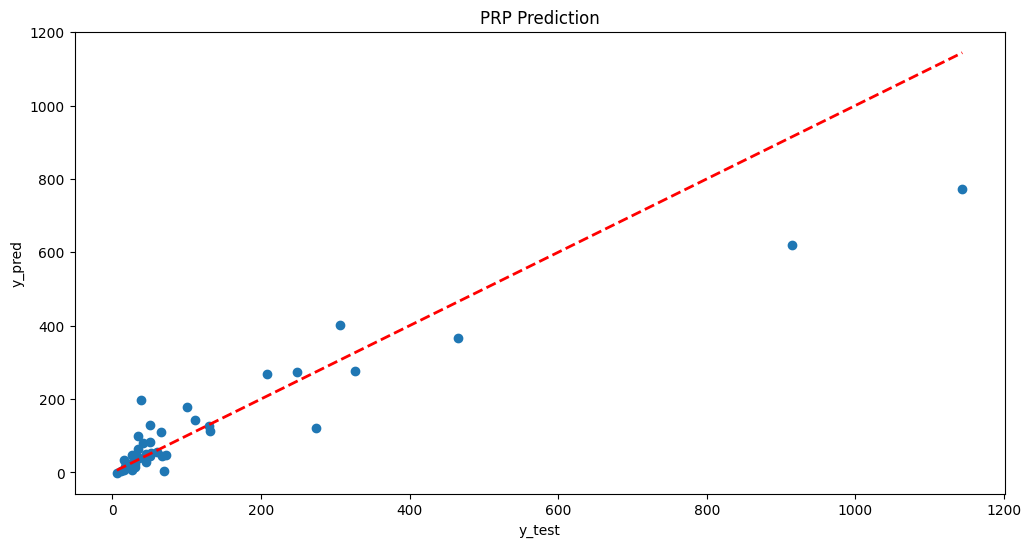

In [139]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.title("PRP Prediction")
plt.savefig('prp_prediction.jpg')

In [140]:
# 교차 검증
cv_score = cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error')
print(cv_score)
cv_mse = -cv_score.mean()
print(f'Cross-Validated MSE: {cv_mse}')

[ -7585.50704258  -1549.2813517    -957.50148041  -2088.27577891
 -19199.6558412 ]
Cross-Validated MSE: 6276.044298961272


In [141]:
# 훈련 세트 및 테스트 세트 예측
train_pred = best_model.predict(X_train)
train_mse = mean_squared_error(y_train, train_pred)
print(f'Training MSE: {train_mse}')

y_test_pred = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f'Testing MSE: {test_mse}')

Training MSE: 3451.294387595062
Testing MSE: 7884.417915482035


   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.005845      0.002196         0.001764        0.000450   
1       0.003049      0.000064         0.001197        0.000090   
2       0.003158      0.000208         0.001183        0.000139   
3       0.002848      0.000058         0.001098        0.000026   
4       0.002791      0.000068         0.001062        0.000014   
5       0.002823      0.000088         0.001102        0.000074   
6       0.002805      0.000134         0.001141        0.000118   
7       0.002824      0.000146         0.001126        0.000050   
8       0.002695      0.000029         0.001101        0.000068   

  param_ensemble__sgd__alpha param_ensemble__sgd__max_iter  \
0                     0.0001                          1000   
1                     0.0001                          2000   
2                     0.0001                          3000   
3                        0.1                          1000   
4                  

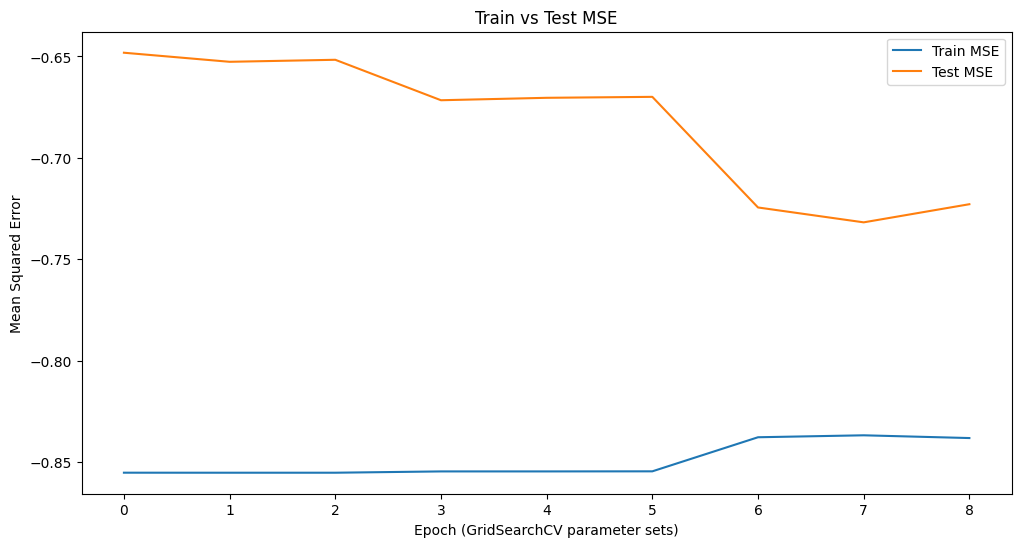

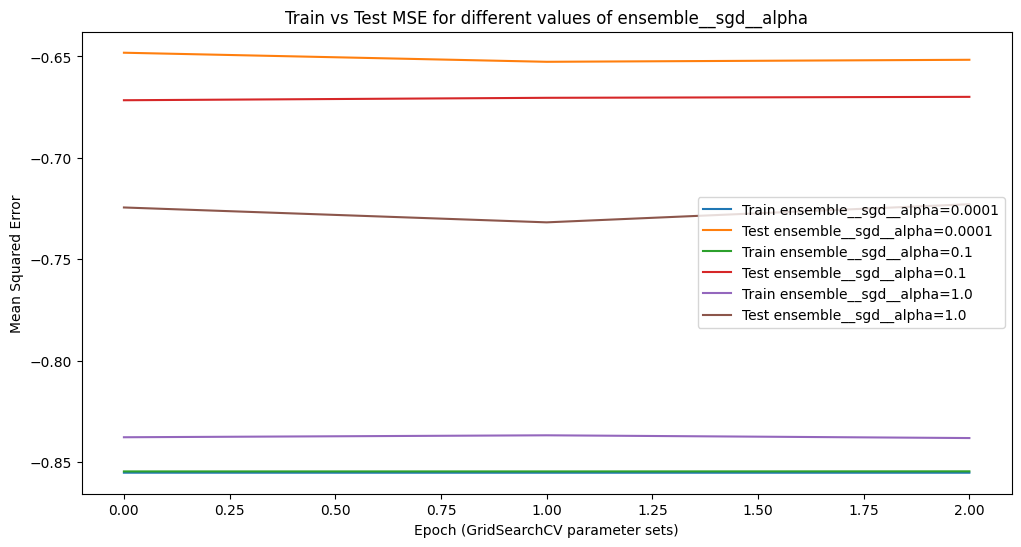

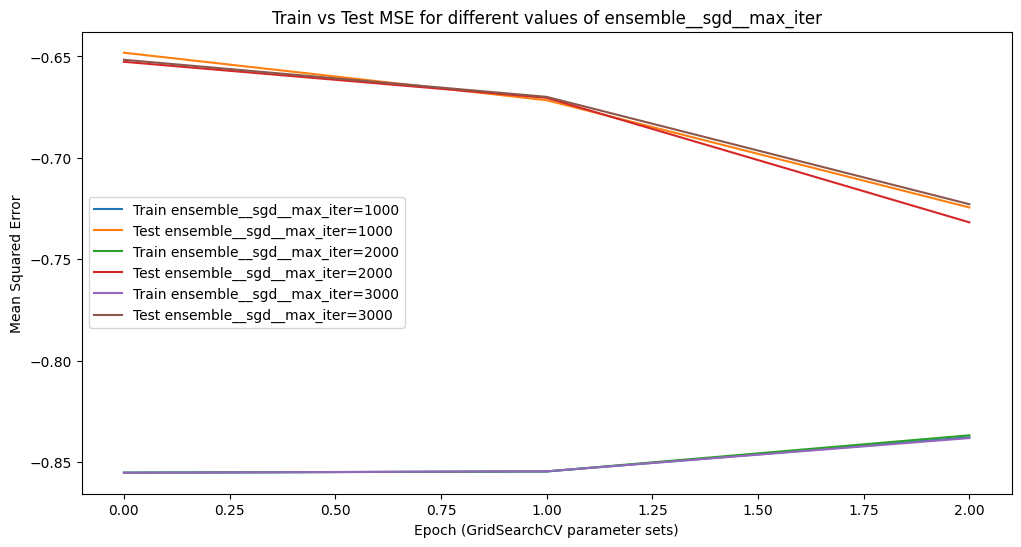

In [142]:
# GridSearchCV 결과 분석
results = pd.DataFrame(grid_search.cv_results_)
print(results)

# 에폭을 X축으로, 훈련 점수 및 테스트 점수 시각화
plt.figure(figsize=(12, 6))
plt.plot(range(len(results['mean_train_score'])), -results['mean_train_score'], label='Train MSE')
plt.plot(range(len(results['mean_test_score'])), -results['mean_test_score'], label='Test MSE')
plt.xlabel('Epoch (GridSearchCV parameter sets)')
plt.ylabel('Mean Squared Error')
plt.title('Train vs Test MSE')
plt.legend()
plt.show()

# 더 많은 파라미터에 대한 시각화
for param in param_grid:
    plt.figure(figsize=(12, 6))
    for value in results['param_' + param].unique():
        subset = results[results['param_' + param] == value]
        plt.plot(range(len(subset)), -subset['mean_train_score'], label=f'Train {param}={value}')
        plt.plot(range(len(subset)), -subset['mean_test_score'], label=f'Test {param}={value}')
    plt.xlabel('Epoch (GridSearchCV parameter sets)')
    plt.ylabel('Mean Squared Error')
    plt.title(f'Train vs Test MSE for different values of {param}')
    plt.legend()
    plt.show()

In [143]:
# 성능 지표 출력
print(f"Testing MSE: {mse}")
print(f"Testing MAE: {mae}")
print(f"Testing R^2: {r2}")

Testing MSE: 7884.417915482035
Testing MAE: 48.09978012156929
Testing R^2: 0.8451206974345946


### 개선된 모델

In [144]:
# 전처리 파이프라인 설정
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # 수치형 데이터 표준화
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features)
    ]
)

# 개별 모델 정의
models = [
    ('lr', LinearRegression()),
    ('sgd', SGDRegressor()),
    ('rf', RandomForestRegressor()),
    ('gbr', GradientBoostingRegressor())
]

# 앙상블 모델 정의
ensemble = VotingRegressor(estimators=models)

# 모델 파이프라인 생성
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ensemble', ensemble)
])

# 하이퍼파라미터 튜닝
param_grid = {
    'ensemble__sgd__alpha': [0.0001, 0.1, 1.0],
    'ensemble__sgd__max_iter': [1000, 2000, 3000]
}

In [145]:
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='r2',
                           return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MYCT',
                                                                          'MMIN',
                                                                          'MMAX',
                                                                          'CACH',
                                                                          'CHMIN',
                                                                          'CHMAX'])])),
                                       ('ensemble',
                                        VotingRegressor(estimators=[('lr',
                                                                     LinearRegression()),
                                                                    ('sgd',
                                                                     SGDRegressor()),
                                                                    ('rf',
                                                                     RandomForestRegressor()),
                                                                    ('gbr',
                                                                     GradientBoostingRegressor())]))]),
             param_grid={'ensemble__sgd__alpha': [0.0001, 0.1, 1.0],
                         'ensemble__sgd__max_iter': [1000, 2000, 3000]},
             return_train_score=True, scoring='r2')

In [146]:
# 최적 모델로 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}, MAE: {mae}, R^2: {r2}")

MSE: 5906.573527155534, MAE: 37.19409926957006, R^2: 0.8839729199741175
